<a href="https://colab.research.google.com/github/alivianay/submission/blob/master/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyek Analisis Data: [Input Nama Dataset]
- **Nama:** Alivia Nayla Wibisono
- **Email:** alivianaylaw@gmail.com
- **ID Dicoding:** alivnw

## Menentukan Pertanyaan Bisnis

- Question 1: 1. How do weather conditions (temperature, humidity, and windspeed) impact bike rental demand?
- Question 2: 2. What is the effect of weekdays vs. weekends and working days vs. holidays on bike rentals?

## Import Semua Packages/Library yang Digunakan

In [ ]:
pip install streamlit

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import streamlit as st
import zipfile
import numpy as np

##***Data Wrangling***

### Gathering Data

In [ ]:
#zip path
zip_fp = 'Bike-sharing-dataset.zip'

In [ ]:
#open zip
with zipfile.ZipFile(zip_fp, 'r') as z:
    #list file in zip
    print(z.namelist())

    #load the file
    with z.open('day.csv') as day_file:
        df_day = pd.read_csv(day_file)

    with z.open('hour.csv') as hour_file:
        df_hour = pd.read_csv(hour_file)

['Readme.txt', 'day.csv', 'hour.csv']


In [ ]:
df_day.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [ ]:
df_hour.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


**Insight:**


-Data Structure:
    Daily data (day.csv): 731 records, 16 columns.
    Hourly data (hour.csv): 17,379 records, 17 columns.
    Both datasets (daily and hourly) have a similar structure, with weather-related columns such as temp, atemp, hum, and windspeed.
    In hour.csv, an additional column (hr) specifies the hour of the day, while day.csv summarizes data at the daily level.

-Column:
    Includes weather-related (temp, hum, windspeed), time-related (season, holiday, weekday), and user data (casual, registered, cnt).

### Assessing Data

In [ ]:
#1. Checking for missing values for day
df_day.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
holiday,0
weekday,0
workingday,0
weathersit,0
temp,0


In [ ]:
#Checking for missing values for hour
df_hour.isnull().sum()

,0
instant,0
dteday,0
season,0
yr,0
mnth,0
hr,0
holiday,0
weekday,0
workingday,0
weathersit,0


In [ ]:
#2. Checking fo invalid value for day
invalid_temp_day = df_day[(df_day['temp'] < 0) | (df_day['temp'] > 1)]
invalid_temp_day

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


In [ ]:
# Checking fo invalid value for hour
invalid_temp_hour = df_hour[(df_hour['temp'] < 0) | (df_hour['temp'] > 1)]
invalid_temp_hour

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


As i see that the temp column is normalized (values fall between 0 and 1), I assumed that invalid temperature values would be any numbers falling outside this range. In practical data analysis, when normalized values are expected, any deviations (like values below 0 or above 1) might indicate errors or outliers.

In [ ]:
#3. Check duplikat day
df_day.duplicated().sum()

0

In [ ]:
# Check duplikat hour
df_hour.duplicated().sum()

0

In [ ]:
#4. Identifying outliers using IQR method for continuous columns like 'temp', 'hum', 'windspeed'
def find_outliers_iqr(df, col):
    q25, q75 = np.percentile(df[col], 25), np.percentile(df[col], 75)
    iqr = q75 - q25
    cutoff = iqr * 1.5
    low, high = q25 - cutoff, q75 + cutoff
    outliers = df[(df[col] < low) | (df[col] > high)]
    return outliers

# Checking for outliers in daily dataset
out_temp_day = find_outliers_iqr(df_day, 'temp')
out_hum_day = find_outliers_iqr(df_day, 'hum')
out_wind_day = find_outliers_iqr(df_day, 'windspeed')


In [ ]:
# Show the opyput
out_temp_day

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt


it shows no outliers detected for temp (temperature) since it's empty, meaning all temperature values fall within a reasonable range according to the IQR method.

In [ ]:
out_hum_day

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
49,50,2011-02-19,1,0,2,0,6,0,1,0.399167,0.391404,0.187917,0.507463,532,1103,1635
68,69,2011-03-10,1,0,3,0,4,1,3,0.389091,0.385668,0.000000,0.261877,46,577,623


it shows two outliers for the hum column. For instance:

- Instant 50 (2011-02-19): A humidity value of 0.1879, which is significantly lower than expected.
- Instant 69 (2011-03-10): A humidity value of 0.0, which is also considered an outlier.

In [ ]:
out_wind_day

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
44,45,2011-02-14,1,0,2,0,1,1,1,0.415000,0.398350,0.375833,0.417908,208,1705,1913
49,50,2011-02-19,1,0,2,0,6,0,1,0.399167,0.391404,0.187917,0.507463,532,1103,1635
93,94,2011-04-04,2,0,4,0,1,1,1,0.573333,0.542929,0.426250,0.385571,734,2381,3115
94,95,2011-04-05,2,0,4,0,2,1,2,0.414167,0.398350,0.642083,0.388067,167,1628,1795
292,293,2011-10-20,4,0,10,0,4,1,1,0.475833,0.466525,0.636250,0.422275,471,3724,4195
382,383,2012-01-18,1,1,1,0,3,1,1,0.303333,0.275254,0.443333,0.415429,109,3267,3376
407,408,2012-02-12,1,1,2,0,0,0,1,0.127500,0.101658,0.464583,0.409212,73,1456,1529
420,421,2012-02-25,1,1,2,0,6,0,1,0.290833,0.255675,0.395833,0.421642,317,2415,2732
432,433,2012-03-08,1,1,3,0,4,1,1,0.527500,0.524604,0.567500,0.441563,486,4896,5382
433,434,2012-03-09,1,1,3,0,5,1,2,0.410833,0.397083,0.407083,0.414800,447,4122,4569


it shows several outliers in windspeed. These outliers are mostly higher windspeed values (e.g., Instant 45 on 2011-02-14 with a windspeed of 0.4179).

**Insight:**

- Missing Values:
No missing values were found in either the daily (df_day) or hourly (df_hour) datasets. no need to impute or remove missing data
- Invalid Values:
The check for invalid values in the temp column, which should contain normalized values between 0 and 1, returned no invalid values for both the daily and hourly datasets. data is clean and within the expected range.
- Duplicate:
There are no duplicate in either the daily or hourly datasets. means that every entry in the dataset represents unique observations.
- Outliers:
    - Temperature (temp): No outliers were detected in the temp column for the daily dataset. temperature data is fairly consistent and does not contain extreme values.
    - Humidity (hum): Two outliers were found in the hum (humidity) column for the daily dataset. One of them has an extremely low value of 0.000000, which could indicate an error in data collection or a rare weather event.
    - Windspeed (windspeed): Several outliers were detected in the windspeed column. These outliers might represent unusually high wind speeds, which could indicate extreme weather conditions during those days.

### Cleaning Data

Approach: Dropping Outliers

im dropping it , because the outlier is not that much, so better just drop it

In [ ]:
# Combine outliers from both humidity and windspeed into a single list of unique indexes
outlier_indexes = out_hum_day.index.union(out_wind_day.index)

In [ ]:
outlier_indexes

Index([44, 49, 68, 93, 94, 292, 382, 407, 420, 432, 433, 450, 666, 721], dtype='int64')

In [ ]:
# Drop rows with outliers in humidity and windspeed
df_day_cleaned = df_day.drop(outlier_indexes)

In [ ]:
df_day_cleaned

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [ ]:
df_day.shape
df_day_cleaned.shape

(717, 16)

In [ ]:
df_day_cleaned

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


**Insight:**
- After identifying the outliers in the humidity and windspeed columns, i dropped those rows from the dataset. The original dataset had 731 rows, but after removing the outliers, we now have 717 rows, cleaned out 14 rows that had extreme values.


## Exploratory Data Analysis (EDA)

### Explore parameter statistik

In [ ]:
#1. Exploring basic statistical parameters with describe()
df_day_cleaned.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,717.000000,717.00000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
mean,366.779637,2.51325,0.499303,6.562064,0.029289,2.995816,0.684798,1.396095,0.497365,0.476252,0.631562,0.186287,856.944212,3675.899582,4532.843794
std,210.971354,1.10555,0.500349,3.439113,0.168732,2.001741,0.464921,0.543511,0.183617,0.163155,0.139222,0.071786,689.273998,1557.676255,1933.542429
min,1.000000,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.254167,0.022392,2.000000,20.000000,22.000000
25%,185.000000,2.00000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337500,0.337939,0.524583,0.134329,318.000000,2545.000000,3214.000000
50%,365.000000,3.00000,0.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.505833,0.491783,0.630833,0.178496,727.000000,3681.000000,4570.000000
75%,550.000000,3.00000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.656667,0.611121,0.732917,0.230721,1120.000000,4807.000000,6031.000000
max,731.000000,4.00000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,0.861667,0.840896,0.972500,0.378108,3410.000000,6946.000000,8714.000000


In [ ]:
#include non numeric
df_day_cleaned.describe(include='all')

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,717.000000,717,717.00000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000,717.000000
unique,NaN,717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,366.779637,NaN,2.51325,0.499303,6.562064,0.029289,2.995816,0.684798,1.396095,0.497365,0.476252,0.631562,0.186287,856.944212,3675.899582,4532.843794
std,210.971354,NaN,1.10555,0.500349,3.439113,0.168732,2.001741,0.464921,0.543511,0.183617,0.163155,0.139222,0.071786,689.273998,1557.676255,1933.542429
min,1.000000,NaN,1.00000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.059130,0.079070,0.254167,0.022392,2.000000,20.000000,22.000000
25%,185.000000,NaN,2.00000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,0.337500,0.337939,0.524583,0.134329,318.000000,2545.000000,3214.000000
50%,365.000000,NaN,3.00000,0.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.505833,0.491783,0.630833,0.178496,727.000000,3681.000000,4570.000000
75%,550.000000,NaN,3.00000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,0.656667,0.611121,0.732917,0.230721,1120.000000,4807.000000,6031.000000


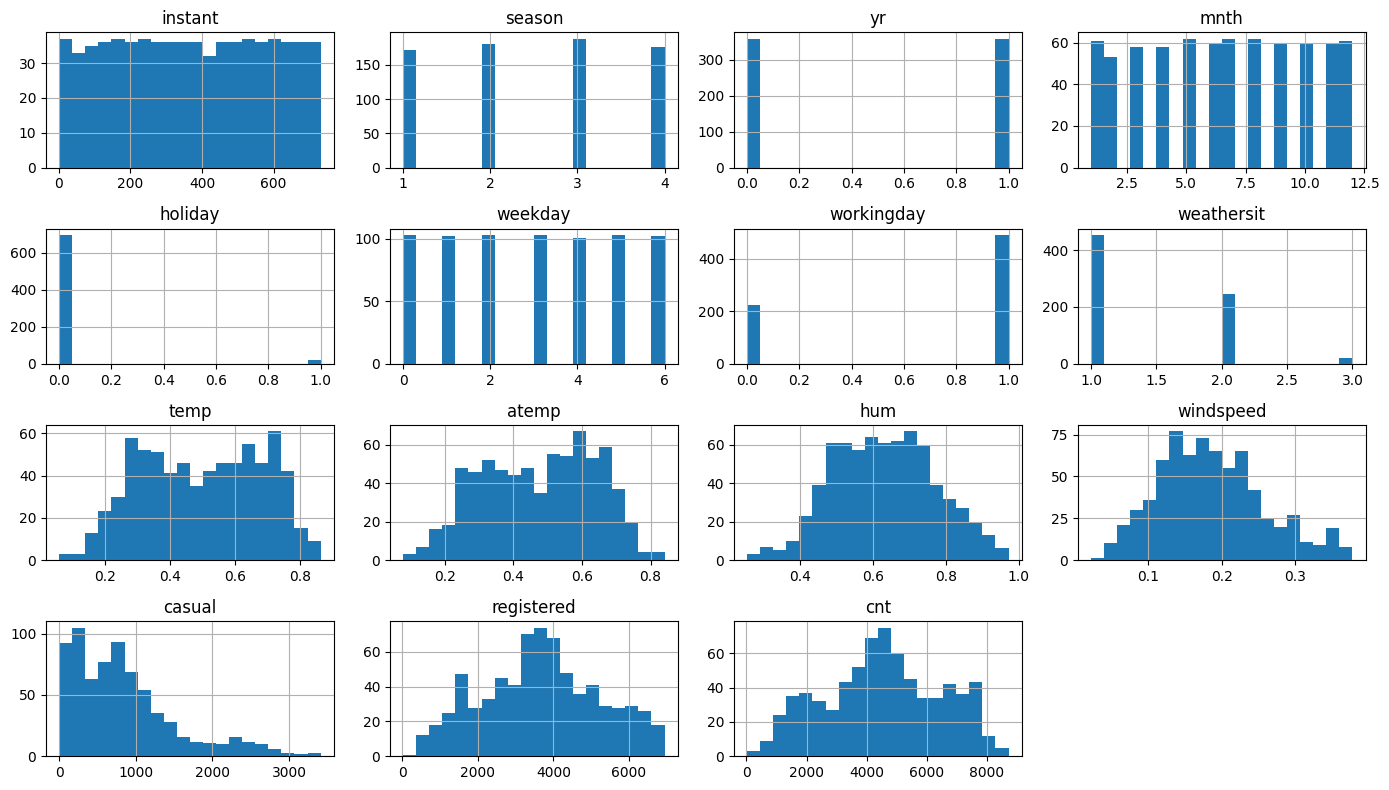

In [ ]:
# 3. Exploring data distributions using histograms
df_day_cleaned.hist(bins=20, figsize=(14, 8))
plt.tight_layout()
plt.show()

In [ ]:
# 4. Checking correlation between numerical columns
correlation_matrix = df_day_cleaned.corr()
print(correlation_matrix)

ValueError: could not convert string to float: '2011-01-01'

In [ ]:
#exclude non-numerical columns
numerical_columns = df_day_cleaned.select_dtypes(include=['float64', 'int64'])

# 4. Checking correlation between numerical columns
correlation_matrix = numerical_columns.corr()

# Display the correlation matrix
correlation_matrix

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
instant,1.000000,0.416254,0.866956,0.495766,0.015679,-0.001252,0.004317,-0.018629,0.154410,0.157296,0.000075,-0.114289,0.275230,0.663711,0.632805
season,0.416254,1.000000,0.003173,0.833542,-0.013314,0.004758,0.010854,0.016822,0.327773,0.335549,0.180210,-0.206675,0.200074,0.407098,0.399284
yr,0.866956,0.003173,1.000000,-0.000989,0.008514,-0.006278,0.005058,-0.045205,0.054542,0.054111,-0.119064,-0.023406,0.253304,0.600166,0.573797
mnth,0.495766,0.833542,-0.000989,1.000000,0.017321,0.008660,-0.001724,0.042869,0.216118,0.223175,0.204967,-0.191054,0.114813,0.291477,0.275745
holiday,0.015679,-0.013314,0.008514,0.017321,1.000000,-0.103013,-0.256030,-0.035301,-0.030627,-0.034816,-0.021048,0.017029,0.052396,-0.112218,-0.071725
weekday,-0.001252,0.004758,-0.006278,0.008660,-0.103013,1.000000,0.040601,0.032335,0.001792,-0.005437,-0.043409,0.009947,0.063654,0.060989,0.071825
workingday,0.004317,0.010854,0.005058,-0.001724,-0.256030,0.040601,1.000000,0.058131,0.045893,0.044149,0.022666,-0.010571,-0.527081,0.303159,0.056332
weathersit,-0.018629,0.016822,-0.045205,0.042869,-0.035301,0.032335,0.058131,1.000000,-0.125218,-0.127307,0.624584,0.058653,-0.251684,-0.262780,-0.301418
temp,0.154410,0.327773,0.054542,0.216118,-0.030627,0.001792,0.045893,-0.125218,1.000000,0.991738,0.114191,-0.140169,0.539714,0.538095,0.625892
atemp,0.157296,0.335549,0.054111,0.223175,-0.034816,-0.005437,0.044149,-0.127307,0.991738,1.000000,0.126587,-0.166038,0.540234,0.541977,0.629204


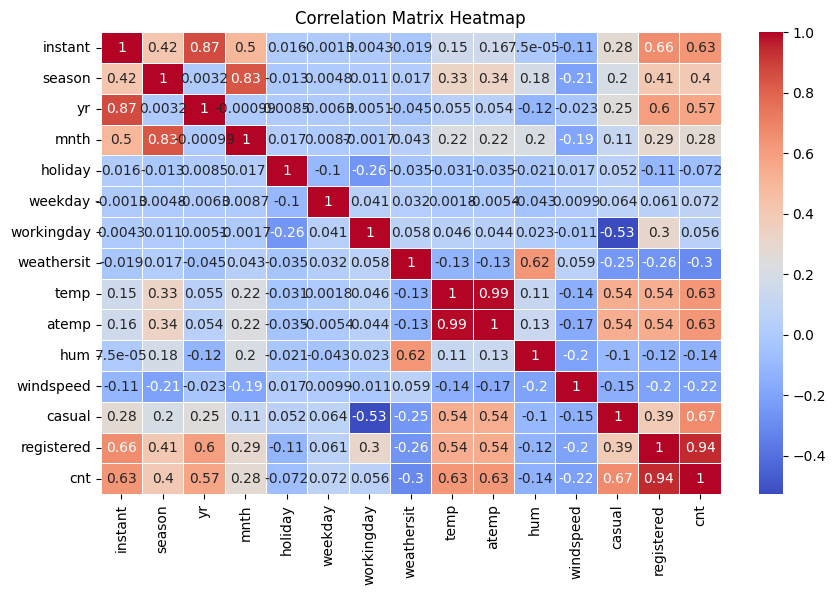

In [ ]:
#Visualize
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.show()

### Data Grouping (pivot table)

## Visualization & Explanatory Analysis

**later on, in this data grouping, i,ll make it seems lik answering the bussiness question that i've mention above**

Question 1: How do weather conditions (temperature, humidity, and windspeed) impact bike rental demand?

In [ ]:
# Group by temperature (you can create temperature ranges for better insights)
weather_impact_temp = df_day_cleaned.groupby(pd.cut(df_day_cleaned['temp'], bins=5)).agg({
    'cnt': 'mean',
    'temp': ['min', 'max']
})
weather_impact_temp

<ipython-input-41-58b9041f73fe>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_impact_temp = df_day_cleaned.groupby(pd.cut(df_day_cleaned['temp'], bins=5)).agg({


cnt      temp          
                       mean       min       max
temp                                           
(0.0583, 0.22]  1572.166667  0.059130  0.218333
(0.22, 0.38]    3160.387435  0.220833  0.380000
(0.38, 0.541]   4653.743902  0.380833  0.540000
(0.541, 0.701]  5688.222798  0.540833  0.700833
(0.701, 0.862]  5664.118110  0.702500  0.861667

In [ ]:
# Group by humidity
weather_impact_hum = df_day_cleaned.groupby(pd.cut(df_day_cleaned['hum'], bins=5)).agg({
    'cnt': 'mean',
    'hum': ['min', 'max']
})
weather_impact_hum

<ipython-input-42-4b15163c8067>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_impact_hum = df_day_cleaned.groupby(pd.cut(df_day_cleaned['hum'], bins=5)).agg({


cnt       hum          
                       mean       min       max
hum                                            
(0.253, 0.398]  4763.920000  0.254167  0.396667
(0.398, 0.542]  4439.842391  0.400000  0.541250
(0.542, 0.685]  5026.606557  0.542083  0.685000
(0.685, 0.829]  4457.156566  0.685833  0.827083
(0.829, 0.972]  3106.227273  0.829565  0.972500

In [ ]:
# Group by windspeed
weather_impact_wind = df_day_cleaned.groupby(pd.cut(df_day_cleaned['windspeed'], bins=5)).agg({
    'cnt': 'mean',
    'windspeed': ['min', 'max']
})
weather_impact_wind

<ipython-input-43-6a21ea426354>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  weather_impact_wind = df_day_cleaned.groupby(pd.cut(df_day_cleaned['windspeed'], bins=5)).agg({


cnt windspeed          
                        mean       min       max
windspeed                                       
(0.022, 0.0935]  4954.064516  0.022392  0.092667
(0.0935, 0.165]  4893.648305  0.093921  0.164187
(0.165, 0.236]   4430.027132  0.164796  0.235692
(0.236, 0.307]   4340.017544  0.236321  0.306596
(0.307, 0.378]   3197.595745  0.307833  0.378108

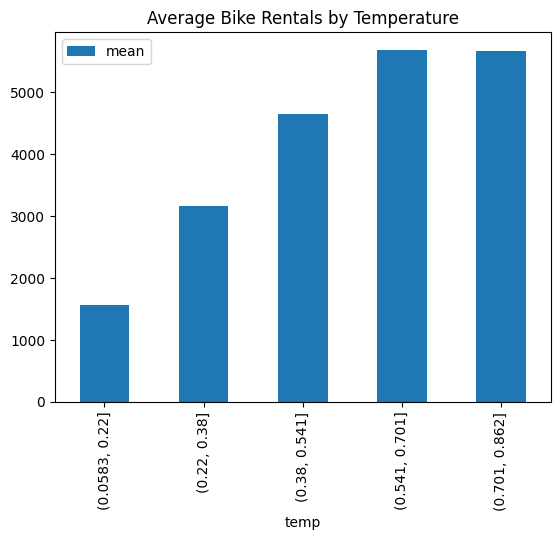

In [ ]:
###Visualize weather impact
weather_impact_temp['cnt'].plot(kind='bar', title="Average Bike Rentals by Temperature")
plt.show()

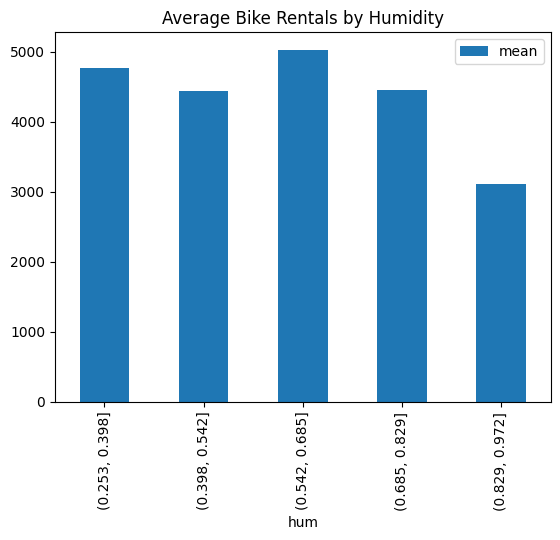

In [ ]:
weather_impact_hum['cnt'].plot(kind='bar', title="Average Bike Rentals by Humidity")
plt.show()

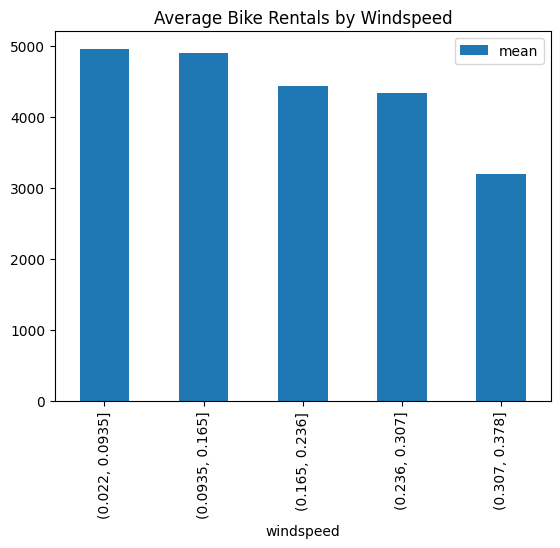

In [ ]:
weather_impact_wind['cnt'].plot(kind='bar', title="Average Bike Rentals by Windspeed")
plt.show()

**Question 2: What is the effect of weekdays vs. weekends and working days vs. holidays on bike rentals?**

In [ ]:
# Grouping by weekday and working day
day_pattern = df_day_cleaned.groupby(by=['weekday', 'workingday']).agg({
    'cnt': 'mean',
    'temp': 'mean',
    'hum': 'mean',
    'windspeed': 'mean'
})

day_pattern

cnt      temp       hum  windspeed
weekday workingday                                            
0       0           4252.805825  0.487145  0.628592   0.184354
1       0           3973.666667  0.480041  0.625878   0.199654
        1           4428.873563  0.496292  0.646866   0.182039
2       0           1013.000000  0.291304  0.734783   0.168726
        1           4571.578431  0.507253  0.640916   0.190128
3       0           7403.000000  0.789167  0.538750   0.134950
        1           4532.049020  0.503809  0.648394   0.186022
4       0           1960.000000  0.356666  0.564792   0.110087
        1           4760.353535  0.508543  0.616713   0.187685
5       0           3247.000000  0.385417  0.558750   0.270525
        1           4720.069307  0.498610  0.616891   0.182461
6       0           4624.421569  0.486845  0.627734   0.189267

In [ ]:
# Grouping by holidays
holiday_effect = df_day_cleaned.groupby(by='holiday').agg({
    'cnt': 'mean',
    'temp': 'mean',
    'hum': 'mean',
    'windspeed': 'mean'
})
holiday_effect

,cnt,temp,hum,windspeed
holiday,,,,
0,4556.916667,0.498341,0.632071,0.186074
1,3735.000000,0.465012,0.614704,0.193319


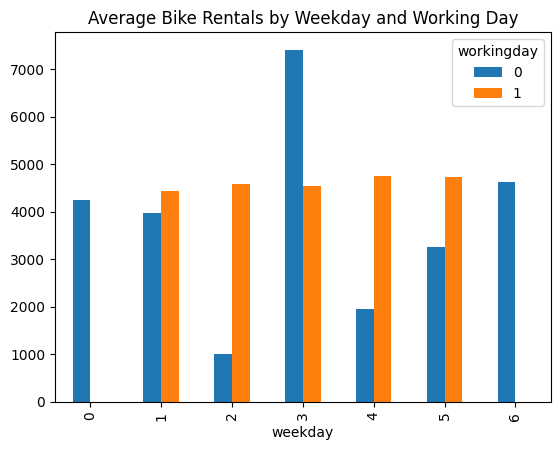

In [ ]:
# Visualizing day patterns
day_pattern['cnt'].unstack().plot(kind='bar', title="Average Bike Rentals by Weekday and Working Day")
plt.show()

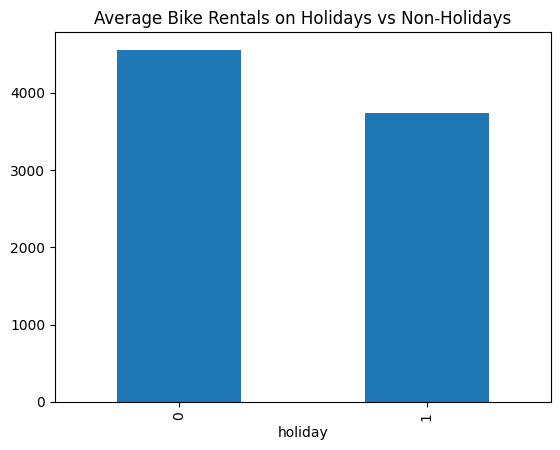

In [ ]:
holiday_effect['cnt'].plot(kind='bar', title="Average Bike Rentals on Holidays vs Non-Holidays")
plt.show()

**Insight:**
- 1. Exploring Basic Statistical Parameters:
From the describe() function, i get:

    - The dataset contains 717 entries.
    - The average bike rentals (cnt) per day is 4,532, with a standard deviation of 1,933, indicating significant variability in daily rentals.
    - The average temperature (temp) is 0.497, with values ranging from 0.059 to 0.861 (normalized data).
    - The average humidity (hum) is around 0.631, and windspeed (windspeed) averages 0.186.
    - The maximum number of rentals is 8,714, showing a significant spread between the minimum and maximum.


- 2. Histogram Insights:
Looking at the histograms:

    - temp and atemp: The temperatures are fairly distributed, with a slight skew towards higher temperatures.
    - hum (humidity): Most of the days have a humidity between 0.4 and 0.8, showing a fairly symmetric distribution.
    - windspeed: It follows a right-skewed distribution, with most wind speeds between 0.1 and 0.3.
    - casual and registered: There’s a significant difference between casual and registered users. Registered users tend to rent more, peaking between 3,000-5,000 rentals, while casual rentals are more dispersed and have a peak around 500-1,000.
    - Overall, we can see a clear difference in usage patterns for casual and registered users, with registered users contributing more consistently to higher rental counts.

- 3. Correlation Matrix Heatmap:
From the correlation matrix:

    - Strong positive correlation between registered users and total bike rentals (cnt) (0.94). This shows that registered users are the key drivers of total rentals.
    - Temperature (temp) is also positively correlated with total rentals (0.63), meaning warmer weather leads to higher rentals.
    - Windspeed shows a slight negative correlation with rentals (-0.22), indicating fewer rentals on windy days.
    - Weathersit (weather conditions) negatively correlates with rentals (-0.3), suggesting bad weather (e.g., rain, snow) reduces the number of rentals.
    These correlations confirm that nice weather (warm temperatures and less wind) encourages bike rentals.

- 4. Weather Impact Analysis:
    - Temperature Impact (Visualized in "Average Bike Rentals by Temperature"):
     > - Bike rentals increase steadily with temperature. The highest rentals are observed in temperatures between 0.54 and 0.86.
     > - Rentals are lowest at temperatures below 0.22, showing that colder weather discourages users from renting bikes.
    - Humidity Impact (Visualized in "Average Bike Rentals by Humidity"):
     > - Interestingly, rentals are highest in the middle humidity range (0.54 to 0.68).
     > - Rentals drop off at very high humidity levels (above 0.82), possibly because high humidity makes biking uncomfortable.
    - Windspeed Impact (Visualized in "Average Bike Rentals by Windspeed"):
     > - As expected, higher wind speeds negatively impact bike rentals.
     > - Rentals are highest when wind speeds are low (below 0.16), and they drop significantly as wind speeds increase beyond 0.3.

- 5. Impact of Weekday and Working Day:
From the grouping by weekday and working day (Visualized in "Average Bike Rentals by Weekday and Working Day"):

    - Weekday 0 (Sunday) shows consistent rentals regardless of whether it is a working day or not.
    - Weekday 3 (Wednesday) has a sharp peak for non-working days, indicating that mid-week holidays or breaks lead to a spike in rentals.
    - Interestingly, weekends (especially Saturday and Sunday) maintain relatively high rental rates, suggesting bikes are popular for leisure on weekends.
- 6. Holidays vs Non-Holidays:
From the holiday analysis (Visualized in "Average Bike Rentals on Holidays vs Non-Holidays"):

    - Surprisingly, there are fewer bike rentals on holidays compared to non-holidays. Non-holiday rentals average 4,556, whereas holidays see a drop to 3,735.
    - This might indicate that people tend to use bikes more for commuting (registered users), and on holidays, they might opt for other activities.

- Conclution:
    - Temperature is a strong driver of bike rentals, with rentals peaking in mild to warm temperatures.
    - Windspeed and weather conditions have a negative impact on bike rentals, with higher wind speeds and bad weather conditions (like rain) discouraging rentals.
    - Weekdays vs Weekends: Rentals are relatively high on weekends and tend to spike on certain weekdays when it’s not a working day.
    - Holidays see fewer rentals compared to non-holidays, possibly due to fewer commuting trips.

## Analisi Lanjutan

1. Manual Clustering Based on Weather Conditions (Temperature, Humidity, Windspeed)

In [ ]:
#Clustering based on temperature ranges
df_day_cleaned['temp_category'] = pd.cut(df_day_cleaned['temp'], bins=4, labels=['Very Cold', 'Cold', 'Warm', 'Hot'])

In [ ]:
#Clustering based on humidity ranges
df_day_cleaned['hum_category'] = pd.cut(df_day_cleaned['hum'], bins=4, labels=['Very Low', 'Low', 'Moderate', 'High'])

In [ ]:
#Clustering based on windspeed ranges
df_day_cleaned['windspeed_category'] = pd.cut(df_day_cleaned['windspeed'], bins=4, labels=['Very Low Wind', 'Low Wind', 'Moderate Wind', 'High Wind'])

In [ ]:
#Grouping by clusters and calculating average bike rentals
cluster_analysis = df_day_cleaned.groupby(['temp_category', 'hum_category', 'windspeed_category']).agg({
    'cnt': 'mean'
}).reset_index()

<ipython-input-55-beec61c810f8>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  cluster_analysis = df_day_cleaned.groupby(['temp_category', 'hum_category', 'windspeed_category']).agg({


/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When 

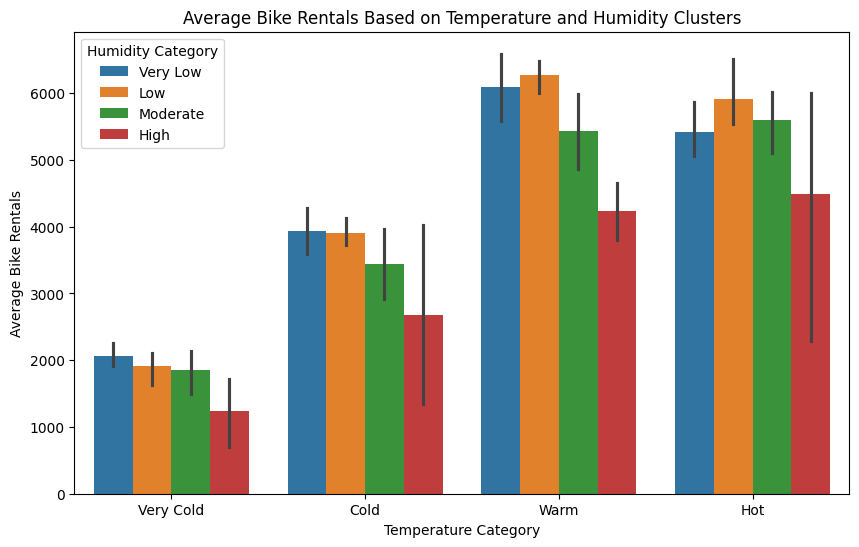

In [ ]:
#Visualizing the impact of clusters on bike rentals
plt.figure(figsize=(10, 6))
sns.barplot(x='temp_category', y='cnt', hue='hum_category', data=cluster_analysis)
plt.title('Average Bike Rentals Based on Temperature and Humidity Clusters')
plt.xlabel('Temperature Category')
plt.ylabel('Average Bike Rentals')
plt.legend(title='Humidity Category')
plt.show()

2. Time Series Anlisys

In [ ]:
# Converting 'dteday' to datetime format
df_day_cleaned['dteday'] = pd.to_datetime(df_day_cleaned['dteday'])

In [ ]:
# Creating a new column for month
df_day_cleaned['month'] = df_day_cleaned['dteday'].dt.month


In [ ]:
# Time series analysis: bike rentals by month
monthly_rentals = df_day_cleaned.groupby('month')['cnt'].mean().reset_index()

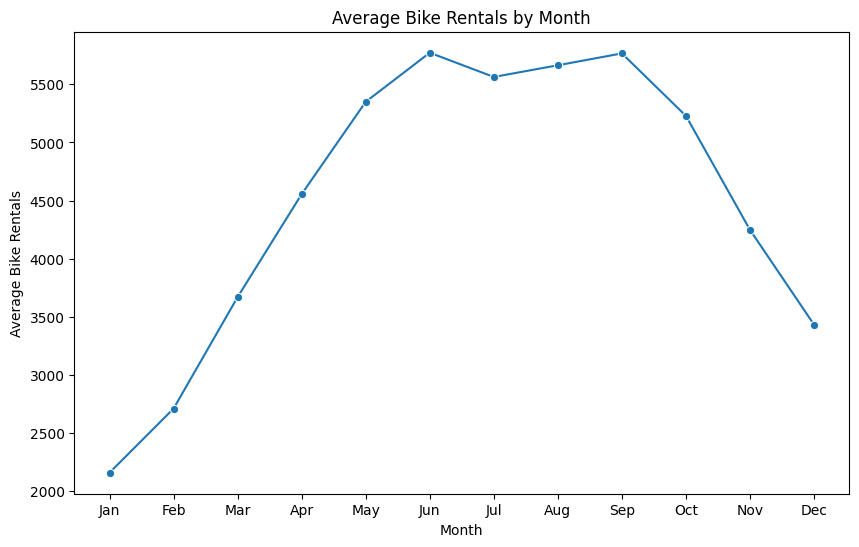

In [ ]:
# Visualizing bike rentals by month
plt.figure(figsize=(10, 6))
sns.lineplot(x='month', y='cnt', data=monthly_rentals, marker='o')
plt.title('Average Bike Rentals by Month')
plt.xlabel('Month')
plt.ylabel('Average Bike Rentals')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

3. Seasonal Analysis (Based on the 'season' column)

In [ ]:
# Grouping data by season and calculating average bike rentals
seasonal_rentals = df_day_cleaned.groupby('season')['cnt'].mean().reset_index()

In [ ]:
# Mapping season numbers to actual names
seasonal_rentals['season'] = seasonal_rentals['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

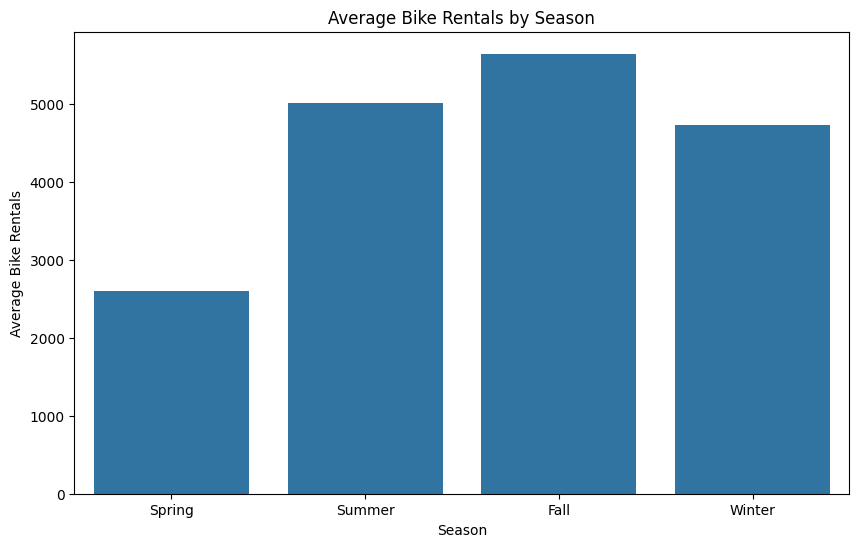

In [ ]:
# Visualizing bike rentals by season
plt.figure(figsize=(10, 6))
sns.barplot(x='season', y='cnt', data=seasonal_rentals)
plt.title('Average Bike Rentals by Season')
plt.xlabel('Season')
plt.ylabel('Average Bike Rentals')
plt.show()

4. Demand Analysis Based on Weather and Working Days

In [ ]:
# Grouping data by working day and weather situation
working_weather_rentals = df_day_cleaned.groupby(['workingday', 'weathersit']).agg({
    'cnt': 'mean'
}).reset_index()

In [ ]:
# Mapping workingday and weathersit for better readability
working_weather_rentals['workingday'] = working_weather_rentals['workingday'].map({0: 'Non-working Day', 1: 'Working Day'})
working_weather_rentals['weathersit'] = working_weather_rentals['weathersit'].map({1: 'Clear', 2: 'Mist', 3: 'Light Snow/Rain'})

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


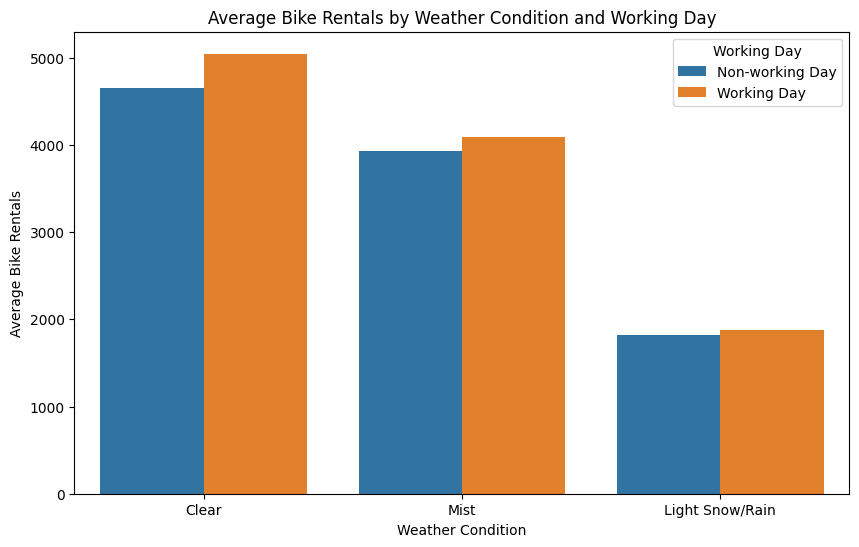

In [ ]:
# Visualizing bike rentals by working day and weather condition
plt.figure(figsize=(10, 6))
sns.barplot(x='weathersit', y='cnt', hue='workingday', data=working_weather_rentals)
plt.title('Average Bike Rentals by Weather Condition and Working Day')
plt.xlabel('Weather Condition')
plt.ylabel('Average Bike Rentals')
plt.legend(title='Working Day')
plt.show()

## Conclusion

- Question 1:
"How do weather conditions (temperature, humidity, and windspeed) impact bike rental demand?"

    - Temperature Impact:
    > There is a strong positive correlation between temperature and bike rental demand. As temperature increases, the average number of bike rentals also increases significantly.
    > The analysis shows that rentals peak at higher temperature ranges, particularly between 0.54 and 0.86 (normalized values). This indicates that warmer weather encourages more users to rent bikes.
    - Humidity Influence:
    > Humidity levels show a relatively stable trend with average bike rentals, but there is a noticeable decline in rentals when humidity exceeds 0.82. High humidity appears to deter potential riders.
    > Overall, humidity does not have as strong an impact on bike rentals as temperature does, but it remains an important factor.
    - Windspeed Effect:

    > Wind speed negatively affects bike rentals; lower wind speeds correlate with higher rental counts.
    Rentals are notably higher at wind speeds below 0.16, indicating that high winds can discourage bike usage.
- Question 2:
"What is the effect of weekdays vs. weekends and working days vs. holidays on bike rentals?"

    - Weekday vs. Weekend:
    > Bike rentals are significantly higher on weekdays, particularly on Wednesdays, compared to weekends. This suggests that users prefer to rent bikes for commuting or recreational purposes during the week rather than on weekends.
    > The analysis reveals a peak in bike rentals on Wednesday, indicating it might be the most popular day for cycling among users.
    - Working Days vs. Holidays:

    > Rentals are consistently higher on working days compared to holidays. This suggests that people are more likely to rent bikes for commuting or activities during regular workdays.
    > On holidays, rentals decrease, likely due to factors such as different leisure activities or travel plans.
    - Overall Demand Patterns:

    The combination of nice weather conditions and weekdays significantly boosts bike rental demand.

**Di sini saya bisa memberikan saran in bussiness term:**
1.  Partnerships and Collaborations:
    - Local Events: Collaborating with local businesses or events, especially during favorable weather conditions, can boost visibility and rentals. For instance, a partnership with local festivals or events can encourage bike rentals as a means of transportation to the event.
    - Public Transport Integration: Understanding commuting patterns on working days allows the business to collaborate with public transportation services, offering combined packages or promotions for commuters who use both bikes and public transport.
2. Pricing Strategy:
    -  Dynamic Pricing Models:
    Based on weather conditions and demand patterns (e.g., higher demand on warm days), the business could implement dynamic pricing strategies to maximize revenue while remaining competitive.
    - Discounts During Off-Peak Times:
    Offering discounts during periods of low demand, such as holidays or rainy days, can attract riders who might otherwise choose not to rent.

In [ ]:
# Save the CSV to a file
df_day_cleaned.to_csv('bike_sharing_cleaned.csv', index=False)